# Apply spaTrack on spatial data of  axolotl brain regeneration after injury

In this tutorial section, we will illustrate the use of spaTrack for inferring cell differentiation trajectories from spatial transcriptomic data obtained during axolotl brain regeneration. Axolotls have the remarkable ability to regenerate damaged brain regions by releasing various cytokines and growth factors. The process of cell differentiation during axolotl brain regeneration has been extensively studied by Wei et al. (2022, Science), and we have obtained a similar cell differentiation trajectory using spaTrack. We will leverage this well-characterized dataset to demonstrate the approach of spaTrack for inferring cell differentiation trajectories. The spatial transcriptomic data for axolotl brain regeneration can be downloaded from our [example data](http://upload.dcs.cloud:8090/share/bb6fab82-2c16-46b2-a95e-6931338f31bf).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import stereo as st

## Loading data and preprocessing

In this data, the cell type information is stored in `data.cells['cluster']` or `data.adata.obs['cluster']`.

In [2]:
data = st.io.read_h5ad('../../data/01.axolotl.brain.regeneration.ST/01.axolotl.brain.regeneration.ST.h5ad')
cluster_res_key = 'cluster'

Running `data.tl.raw_checkpoint()` to save the raw expression matrix for use when needed.

In [3]:
data.tl.cal_qc()
data.tl.filter_genes(min_cells=10)
data.tl.raw_checkpoint()
data.tl.normalize_total()
data.tl.log1p()

[2024-11-05 13:49:49][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run cal_qc...
[2024-11-05 13:49:49][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: cal_qc end, consume time 0.0736s.
[2024-11-05 13:49:49][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run filter_genes...
[2024-11-05 13:49:49][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: filter_genes end, consume time 0.1003s.
[2024-11-05 13:49:49][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run normalize_total...
[2024-11-05 13:49:49][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: normalize_total end, consume time 0.0273s.
[2024-11-05 13:49:49][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run log1p...
[2024-11-05 13:49:49][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: log1p end, consume time 0.0474s.


Visualize the cell type information

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

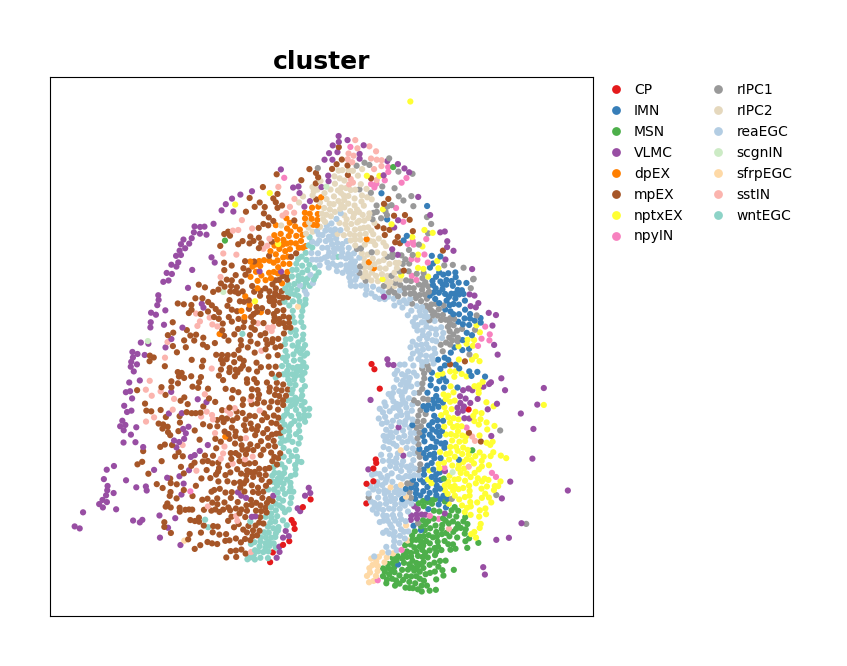

In [4]:
data.plt.cluster_scatter(res_key=cluster_res_key, invert_y=False, marker='o', dot_size=20, show_plotting_scale=False)

**readEGC**:  reactive ependymoglial cells;  
**rIPC**:  regeneration intermediate progenitor cells;  
**IMN**:  immature neuron;  
**nptxEX**:  Nptx+ lateral pallium excitatory neurons;  
**MSN**:  medium spiny  neuron;  
**sfrpEGC**:  sfrp+ ependymoglial cells;  
**CP**:  choroid plexus;  
**VLMC**:  vascular leptomeningeal cell;  
**wntEGC**:  Wnt+ EGC;  
**mpEX**:  medial pallium excitatory neuron;  
**sstIN**:  Sst+ inhibitory neuron;  
**scgnIN**:  Scgn+ inhibitory neuron;  
**dpEX**:  dorsal palliumexcitatory neuron; 

## Get An object of spaTrack

Set the cell type information to be used through parameter `cluster_res_key`.

In [5]:
spt = data.tl.spa_track(cluster_res_key=cluster_res_key)

2024-11-05 13:49:51.790535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-11-05 13:49:53][Stereo][14873][MainThread][139727250700096][st_pipeline][77][INFO]: register algorithm spa_track to <stereo.core.st_pipeline.AnnBasedStPipeline object at 0x7f144ba80a60>


## Choose start cells

Before inferring a cell differentiation trajectory using spaTrack, we need to select a starting cluster or specify a group of cells as the beginning of the trajectory. This step is crucial in ensuring the reliability of the inferred trajectory.

In spaTrack, we provide a methods to determine the starting cluster including automatically and manually select starting cluster. We recommend that users manually select starting cluster base on prior knowledge and biological evidence.

One way to select a starting cluster is to identify a cluster that has a higher entropy value. 

Alternatively, users can manually select a starting point by specifying spatial coordinates or by using the lasso function to circle cells of interest.

For our analysis of axolotl brain regeneration data, we manually selected **reaEGC** (reactive EGC) cells as the starting cells since they cover the injury site and have higher entropy value. 

To facilitate the identification of specific interesting regions, we provide an interactive function that allows users to circle the region of interest and obtain the corresponding cell coordinates.

### Method 1: Automatically determining the starting cluster

Assese entropy value in each cluster to identify the starting cluster. The larger the entropy, the higher the uncertainty of the random variable, and the greater the amount of information.In spaTrack, higher entropy value indicate more likely to be starting cluster.

The `spt.assess_start_cluster()` function outputs the entropy value for each cluster.

The `spt.assess_start_cluster_plot()` function displays boxplot of the sorted entropy value for each cluster.

readEGC has the highest entropy value , it is more likely to be the starting cluster.

In [6]:
spt.assess_start_cluster()

[2024-11-05 13:49:54][Stereo][14873][MainThread][139727250700096][start_cluster][34][INFO]: Cluster order sorted by entropy value: ['reaEGC', 'rIPC2', 'IMN', 'MSN', 'rIPC1', 'wntEGC', 'sfrpEGC', 'dpEX', 'npyIN', 'nptxEX', 'mpEX', 'sstIN', 'CP', 'VLMC', 'scgnIN']


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

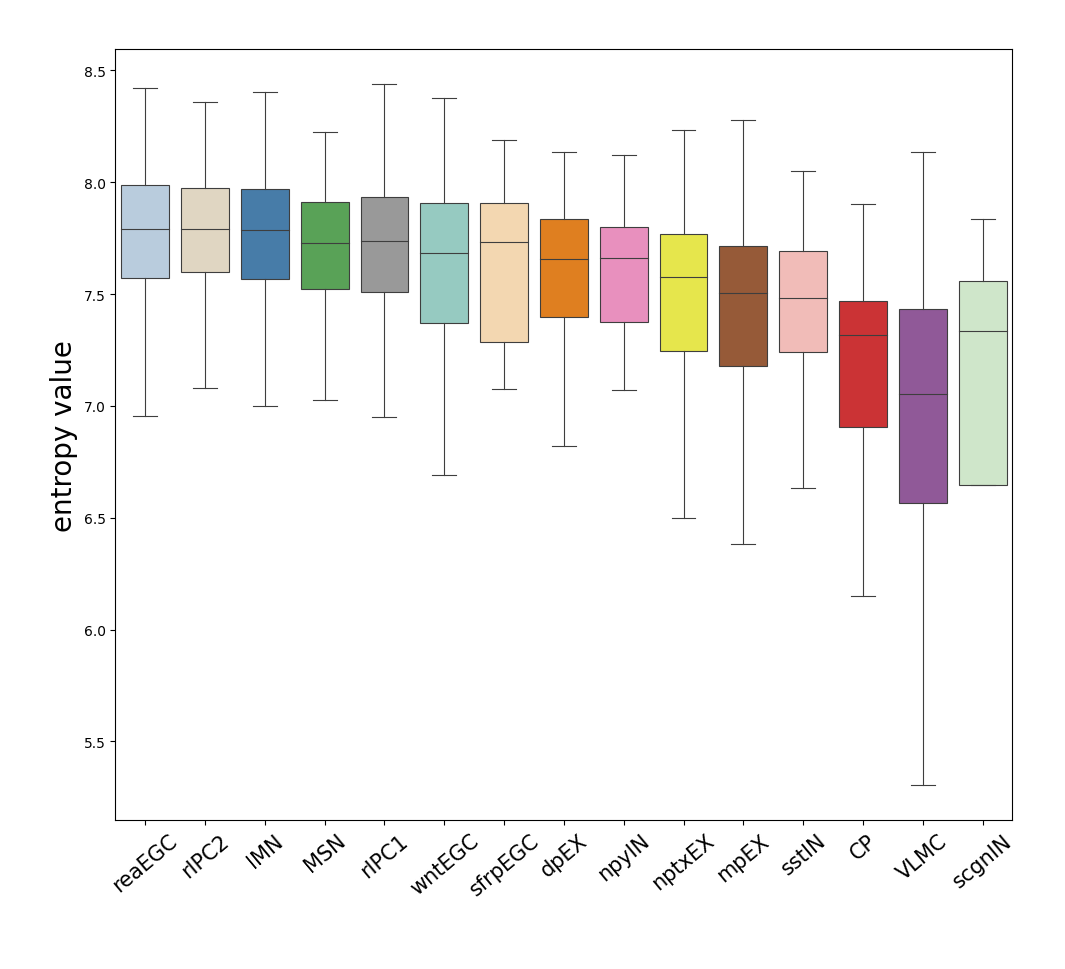

In [7]:
spt.plot.assess_start_cluster_plot()

### Method 2: Manually select start cells

It is recommended that users manually select the starting cluster based on prior knowledge and biological evidence. In the absence of such knowledge, users can refer to the above result, which was automatically determined starting cluster

#### Select start cells by coordinates

It will select the start cells that only contain the cell type specified by `cell_type` from the region determined by `start_point` and `n_neigh`.

In [8]:
start_cells = spt.set_start_cells(select_way='coordinates', cell_type='reaEGC', start_point=[-1050,3850], n_neigh=30)

#### Select start cells by cell type

In [9]:
# spt.set_start_cells(adata, select_way='cell_type', cell_type='reaEGC')

### Method 3: Interactively select start cells by lasso

In [10]:
# spt.lasso_select(invert_y=False)

Visualize the start cells.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

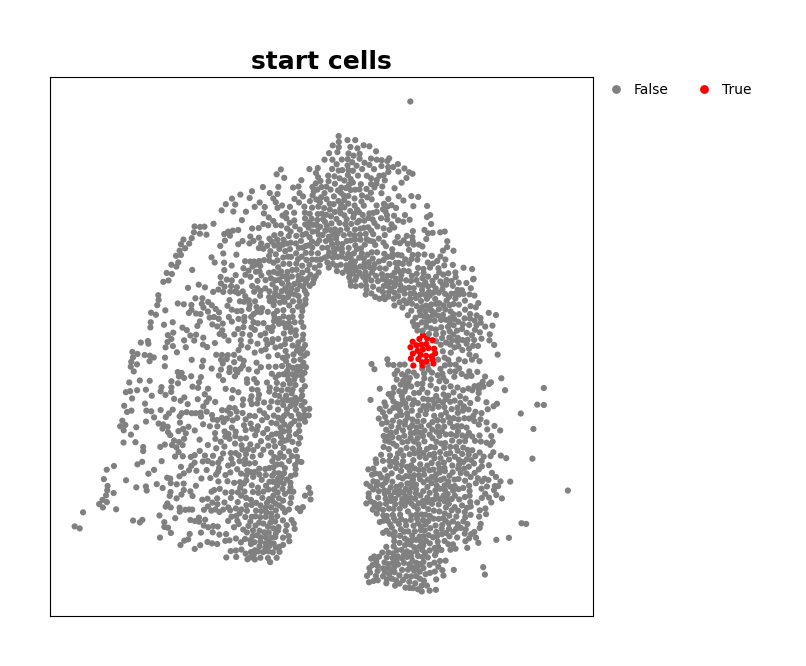

In [11]:
data.plt.cluster_scatter(
    res_key='start_cells',
    marker='o',
    dot_size=20,
    title='start cells',
    invert_y=False, 
    show_plotting_scale=False,
    palette=['gray', 'red'])

## Calculate cell transition probability

To calculate the trajectory velocity from spatial transcriptomics data using spaTrack, we first input the gene expression matrix (N x M, where N is the number of cells and M is the number of genes) and use optimal transport theory to calculate the cell transition probability matrix (N x N).

In the case of axolotl brain regeneration spatial transcriptomics data, we set the data type as **spatial** to incorporate the cell spatial position information and obtain more accurate cell transition probability values.

The default parameters for **alpha1** and **alpha2** in `spt.get_ot_matrix` are set to equal with 0.5 and 0.5, assuming that gene expression and spatial distance are independent.

We also provide a method `spt.calc_alpha_by_moransI` using moran'I to estimate **alpah1** and **alpah2** as a reference from input ST data .

In [12]:
alpha1, alpha2 = spt.calc_alpha_by_moransI()
alpha1, alpha2

[2024-11-05 13:50:37][Stereo][14873][MainThread][139727250700096][velocity][387][INFO]: Morans'I value is 0.18080423124721207, the estimated values of alpha1 and alpha2 are 0.8468804341459384 and 0.1531195658540616.


(0.8468804341459384, 0.1531195658540616)

In [13]:
spt.get_ot_matrix(data_type="spatial", alpha1=0.5, alpha2=0.5)
# spt.get_ot_matrix(data_type="spatial", alpha1=alpha1, alpha2=alpha2)

[2024-11-05 13:50:37][Stereo][14873][MainThread][139727250700096][velocity][88][INFO]: Can not find PCA result, to calculate automatically using highly variable genes.
[2024-11-05 13:50:37][Stereo][14873][MainThread][139727250700096][velocity][89][INFO]: n_pcs: 50
[2024-11-05 13:50:37][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run pca...
[2024-11-05 13:51:07][Stereo][14873][MainThread][139727250700096][dim_reduce][99][INFO]: x_pca dType is changed from float64 to float32
[2024-11-05 13:51:07][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: pca end, consume time 29.7896s.
[2024-11-05 13:51:07][Stereo][14873][MainThread][139727250700096][velocity][124][INFO]: alpha1(gene expression): 0.5   alpha2(spatial information): 0.5


array([[0.00000000e+00, 8.89571426e-07, 1.23572538e-06, ...,
        2.66033619e-09, 3.36144748e-09, 1.23705422e-07],
       [8.89571426e-07, 0.00000000e+00, 1.29250787e-06, ...,
        2.45490155e-09, 1.53379912e-09, 3.05171647e-08],
       [1.23572538e-06, 1.29250787e-06, 0.00000000e+00, ...,
        2.75410311e-09, 1.80328696e-09, 4.64308497e-08],
       ...,
       [2.66033619e-09, 2.45490155e-09, 2.75410311e-09, ...,
        0.00000000e+00, 1.46074923e-06, 3.37688477e-07],
       [3.36144748e-09, 1.53379912e-09, 1.80328696e-09, ...,
        1.46074923e-06, 0.00000000e+00, 5.69267252e-07],
       [1.23705422e-07, 3.05171647e-08, 4.64308497e-08, ...,
        3.37688477e-07, 5.69267252e-07, 0.00000000e+00]])

## Caculate cell pseudotime

After calculating the cell transition probability matrix, we calculate the sum of probabilities of all initial cells transferring to each cell. Next, we sort all the cells based on the sum of transition probabilities from largest to smallest.

To assign a value between 0-1 as ptime for each cell, we use an arithmetic sequence. The cell with the largest sum of transition probabilities is assigned a ptime value of 0, while the cell with the smallest sum is assigned a ptime value of 1. The cells in between are assigned ptime values based on their sort order.

In [14]:
spt.get_ptime()

array([0.85344468, 0.77411273, 0.76158664, ..., 0.53402923, 0.62505219,
       0.4217119 ])

Visualize the pseudotime of cells

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

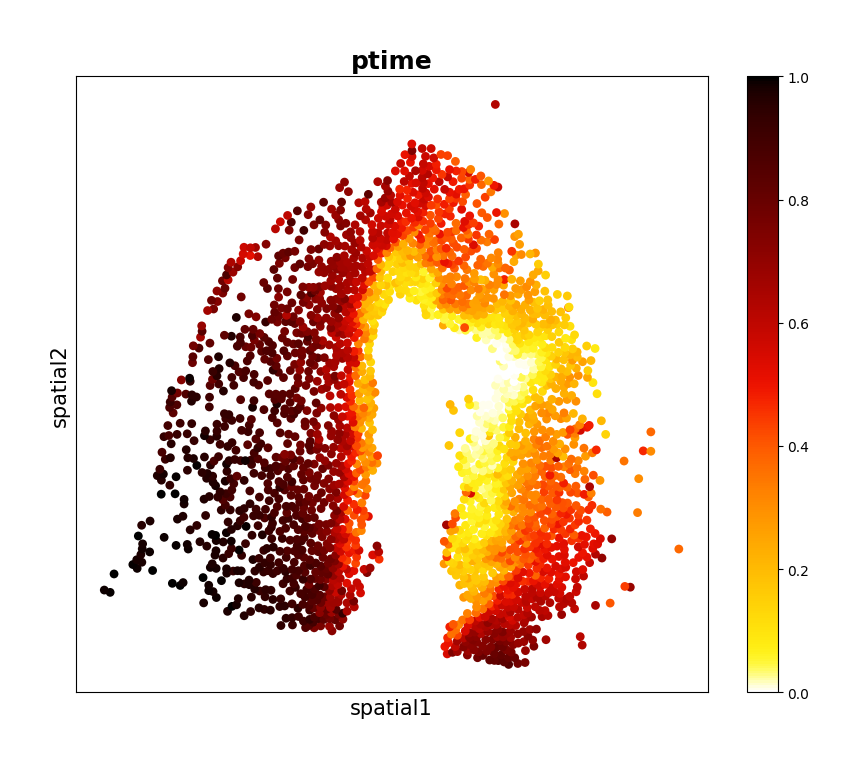

In [15]:
data.plt.spatial_scatter(cells_key='ptime', marker='o', dot_size=40, palette='fire', color_bar_reverse=True, invert_y=False, show_plotting_scale=False)

## Calculate vector field velocity

After assigning ptime values to each cell, we need to determine the cell neighbors, which is an important factor for cell velocity. The cell neighbors can be determined based on the cell spatial coordinates, corresponding to the parameters `n_neigh_pos`. For spatial data, we use `spatial` coordinates. `umap` is used for scRNA data. We use the intersection of the spatial coordinate neighbors and embedding matrix neighbors to determine the cell neighbors.

For each cell, we take the direction from the cell point to the neighbor as the vector field speed direction. If the neighbor cell's pseudotime value is larger than the cell, we reverse the speed direction. After determining the vector field speed direction, we use the cell transition probability of the cell to its neighbors as the conjunctive speed in the vector field. The final velocity of the cell depends on the average conjunctive speed value to its neighboring cells.

To present the cell velocity in a streamline plot, we divide the two-dimensional planes into 50x50 grids and convert the cell velocity into grid velocity. We then select the average speed of the neighboring cells near the grid point as the speed of the grid point. The distance from the cell to the grid point determines the weight of the cell speed, with cells closer to the grid point having a larger weight.

In [16]:
spt.get_velocity(spatial_key='spatial', n_neigh_pos=50)

Cell quiver plot

In the quiver plot, the length of the arrow can be adjusted by adjusting the `quiver_scale` attribute. The smaller the scale, the longer the arrow.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

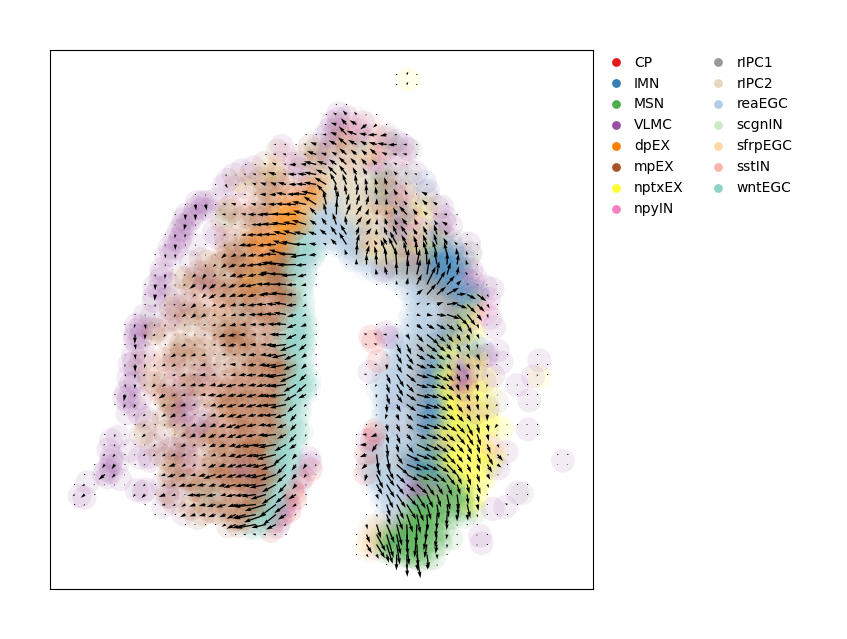

In [17]:
spt.plot.quiver(alpha=0.1, dot_size=300, quiver_scale=0.008, invert_y=False)

Cell trajectory plot

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

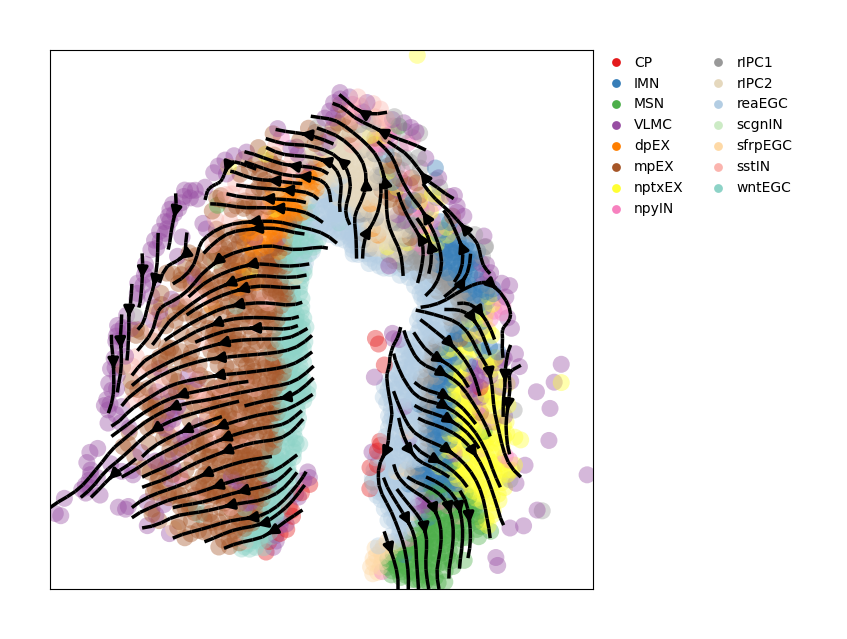

In [18]:
spt.plot.stremplot(dot_size=150, invert_y=False)

## Downstream analysis

After inferring the cell differentiation trajectory, we can focus on a group of cell types that undergo a branching in the trajectory, which may play a critical role in brain regeneration after injury. To predict the optimal transition path of cell fate transition, we use the least action path (LAP) algorithm, which identifies the most probable path for cells to transition between different cell states while minimizing the overall energy required for the transition. By using the LAP algorithm, we can identify key driver genes of cell-fate transitions in the trajectory branching.

### Least Action Path (LAP)

To effectively apply the least action path (LAP) method to spatial transcriptomics data, we have refined the algorithm by reconstructing the vector field at the cell level. This allows us to find the trajectory that best fits the vector field and eliminate any potential interference caused by weakly correlated cells in the trajectory. The LAP algorithm relies on the velocity of each cell to infer the optimal transition path, hence the need to reconstruct the grid-level vector field into a cell-level format.

In [19]:
spt.create_vector_field()

To infer the least action path (LAP) of the trajectory, users need to specify a starting and an ending cell by using `spt.set_lap_endpoints`. LAP algorithm utilizes the velocity of each cell to infer the optimal transition path between the two specified cells. It searches for the path that minimizes the action integral, which is a measure of the total kinetic energy along the path. This optimal path reflects the most likely transition of cells between the two specified cells based on their velocity field.

In [20]:
LAP_start_point=[-1050,3850]
LAP_end_point=[-625,3000]

spt.set_lap_endpoints(
    LAP_start_point, LAP_end_point
)

Visualize the starting and ending cells

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

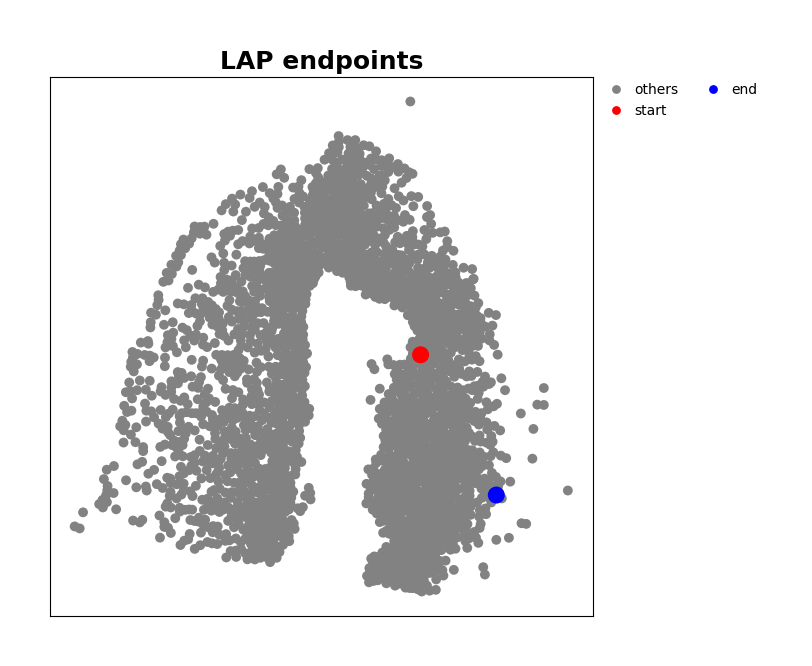

In [21]:
spt.plot.lap_endpoints(invert_y=False)

LAP is a method that can determine the optimal path between a given starting point (LAP_start_point) and end point (LAP_end_point) based on cell velocity. It does so by utilizing an Expectation-Maximization algorithm to search for the path with the lowest action, and iteratively updating the optimal path until convergence. Users can adjust the number of `EM_steps` taken by the algorithm to obtain a more smooth and optimal path, known as the Least Action Path.

In [22]:
lap = spt.least_action(
    n_points = 20,
    EM_steps = 5
)

[2024-11-05 13:51:28][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run neighbors...
[2024-11-05 13:51:34][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: neighbors end, consume time 5.6815s.


After selecting cells along the focused trajectory branching using the LAP, we assign a new pseudotime value to each of these cells based on their position along the LAP. We then plot the LAP to visualize the optimal transition path of the focused trajectory branching. This can provide insights into the progression of cell fate transitions and potential key driver genes along this trajectory.

In [23]:
spt.map_cell_to_LAP(cell_neighbors=80)

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

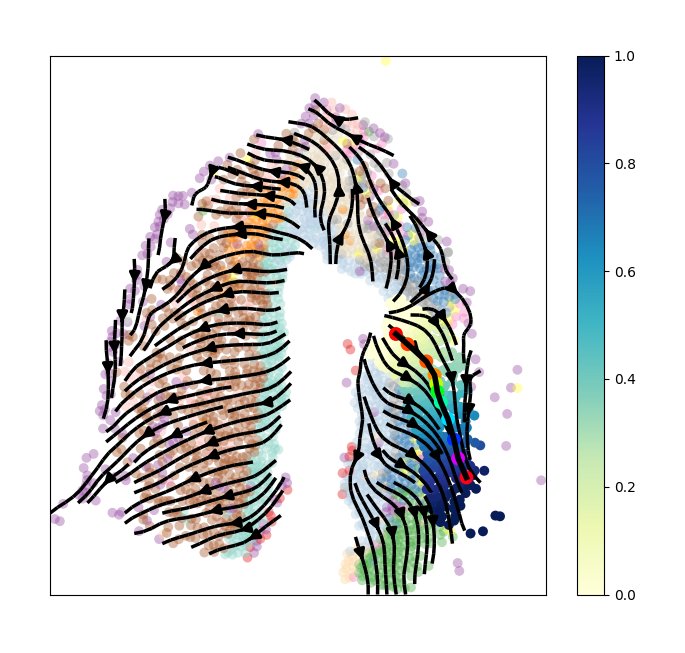

In [32]:
spt.plot.least_action_path(invert_y=False, width=800)

### Pseudotime-dependent genes on LAP

To identify genes that drive cell transition along the optimal transition path, we fit gene expression values and cell pseudotime values using the Generalized Additive Model (GAM). This allows us to identify genes that are significantly associated with pseudotime values,and are therefore considered pseudotime-dependent genes.

First,we choose focused cell type on optimal transition path and filter genes with high variability and expression levels greater than a minimum expression proportion.

In [25]:
data_filtered = spt.filter_genes(
    min_exp_prop_in_genes=0.1, n_hvg=3000, focused_cell_types=['reaEGC','rIPC1', 'IMN','nptxEX']
)

[2024-11-05 13:51:37][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run highly_variable_genes...
[2024-11-05 13:51:37][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: highly_variable_genes end, consume time 0.4360s.
[2024-11-05 13:51:37][Stereo][14873][MainThread][139727250700096][Pgene][121][INFO]: Cell number	256
[2024-11-05 13:51:37][Stereo][14873][MainThread][139727250700096][Pgene][122][INFO]: Gene number	1097


Then, we fit gene expression and corresponding cell pseudotime using Generalized Additive Model.

To filter pseudotime-dependent genes, we evaluated the quality of the model fit by calculating the R2 value. We also controlled for false discovery rate (FDR) using multiple testing correction. Genes with a high R2 value and a low FDR were considered as pseudotime-dependent genes, which may be important in driving cell-fate transitions along the optimal transition path.

In [26]:
df_res = spt.ptime_gene_GAM(data_filtered)

[2024-11-05 13:51:37][Stereo][14873][MainThread][139727250700096][Pgene][208][INFO]: Genes number fitted by GAM model:  1097


In [27]:
sort_exp_sig = spt.order_trajectory_genes(df_res, min_model_fit=0.2, max_fdr=0.05, cell_number=20)

[2024-11-05 13:52:02][Stereo][14873][MainThread][139727250700096][Pgene][319][INFO]: Finally selected 49 genes.


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

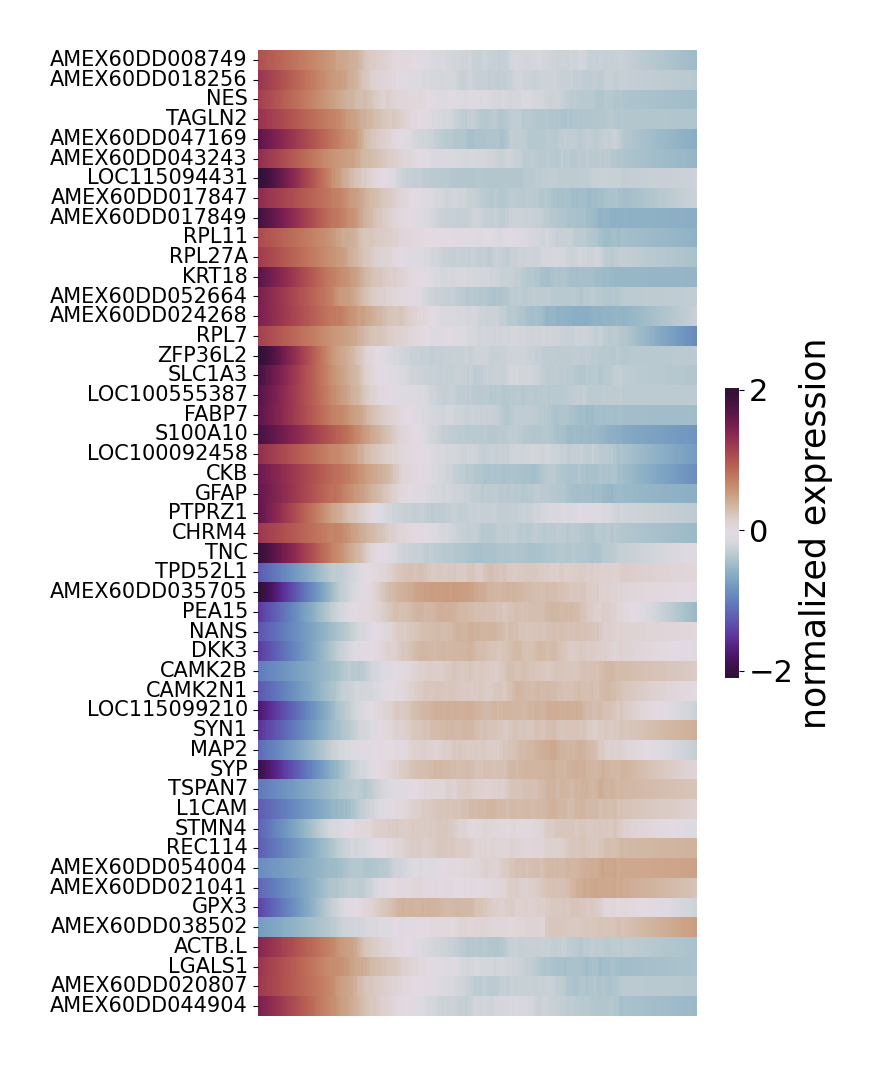

In [28]:
spt.plot.trajectory_gene_heatmap(sort_exp_sig, smooth_length=100, gene_label_size=15)

Display the expression of a single key gene along ptimes.

[2024-11-05 13:52:03][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run highly_variable_genes...
[2024-11-05 13:52:03][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: highly_variable_genes end, consume time 0.1569s.
[2024-11-05 13:52:03][Stereo][14873][MainThread][139727250700096][Pgene][121][INFO]: Cell number	256
[2024-11-05 13:52:03][Stereo][14873][MainThread][139727250700096][Pgene][122][INFO]: Gene number	1097


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

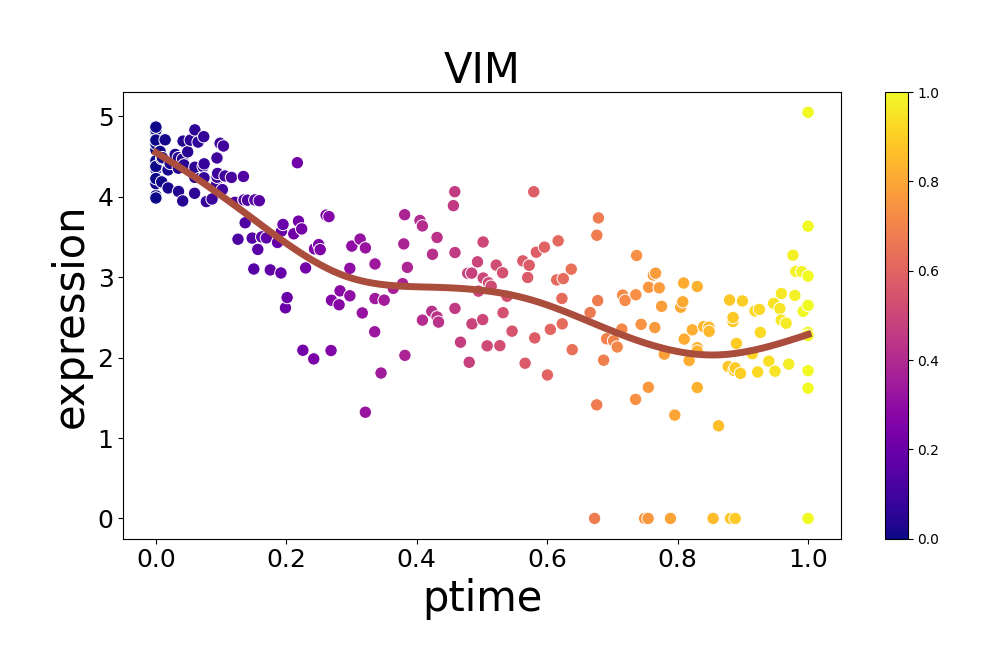

In [29]:
spt.plot.trajectory_gene(gene_name='VIM',dot_size=80, show_cell_type=False)

[2024-11-05 13:52:04][Stereo][14873][MainThread][139727250700096][st_pipeline][41][INFO]: start to run highly_variable_genes...
[2024-11-05 13:52:04][Stereo][14873][MainThread][139727250700096][st_pipeline][44][INFO]: highly_variable_genes end, consume time 0.1479s.
[2024-11-05 13:52:04][Stereo][14873][MainThread][139727250700096][Pgene][121][INFO]: Cell number	256
[2024-11-05 13:52:04][Stereo][14873][MainThread][139727250700096][Pgene][122][INFO]: Gene number	1097


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

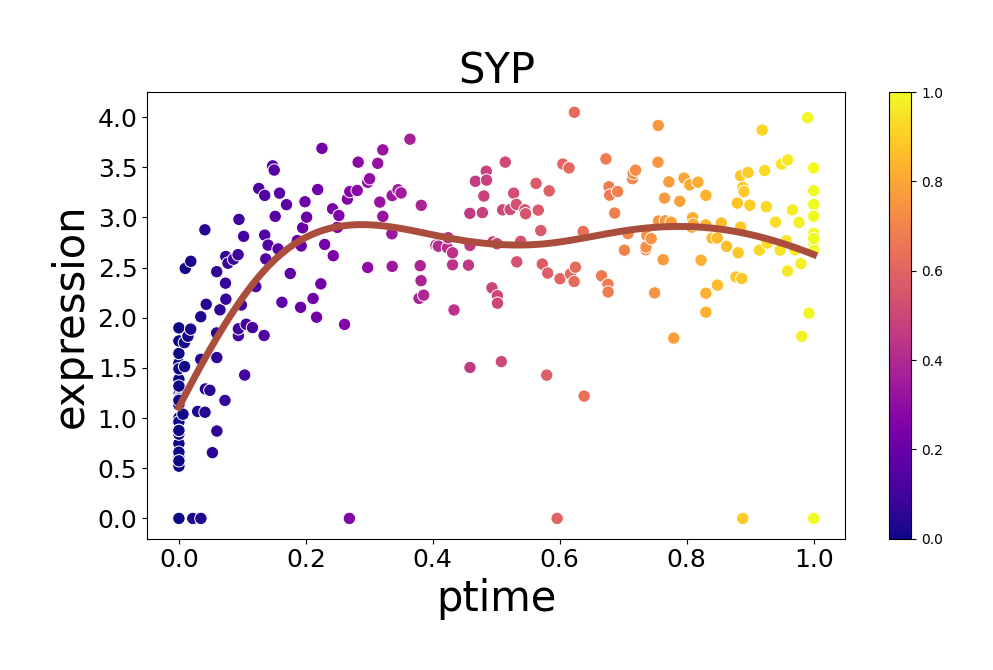

In [30]:
spt.plot.trajectory_gene(gene_name='SYP',dot_size=80, show_cell_type=False)